In [25]:
%reset -f -s

In [ ]:
'''------------------------------------------------------------------
---------------------------------------------------------------------
LSTM Training
---------------------------------------------------------------------
Version: V1.7       Modified: 06.11.2024        William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
------------------------------------------------------------------'''
#import pathlib
from pathlib import Path, WindowsPath, PosixPath


# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "GPU_SELECT":       3, # {0,1,2,3, None: CPU only}
    "SEED"  :           100,
    "PLOT_ACTIVE":      True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.19, 0.01], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()', 'target_scaler': 'MinMaxScaler(feature_range=(0, 1))'},
    "MIN_SEQ_LENGTH":   600, # minimum sequence length in s to be included in DataSets

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['actdrvtrnpwrprc_cval','altitude_cval_ippc','motortemperature_pti1',
                        'brktempra_cval','hv_batmaxdischrgpwrlim_cval_1',
                        'emot_pwr_cval','actualtorque_pti1','powerstagetemperature_pti1',
                        'accelpdlposn_cval','airtempoutsd_cval_cpc','airtempinsd_cval_hvac','actualdcvoltage_pti1','hv_batavcelltemp_cval_bms1',
                        'epto_pwr_cval','maxtracpwrpct_cval','airtempinsd_rq','bs_brk_cval','brc_stat_brc1','vehspd_cval_cpc',
                        'vehweight_cval_pt','actualspeed_pti1','selgr_rq_pt',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval',
                        'hv_ptc_cabin1_pwr_cval','maxrecuppwrprc_cval','txoiltemp_cval_tcm'],
    "TARGETS":          ['hv_bat_soc_cval_bms1'],

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      400,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.5,
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       10,
    "BATCH_SIZE":       64,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "LEARNING_RATE":    7e-3,   # 0.001 lr
    "OPTIMIZER":        "torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-3)",      
                        # weight_decay = 1e-4     # weight decay coefficient (default: 1e-2)
                        # betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
                        # eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-7)",

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    "LOSS_FN":          "F.mse_loss(output, target)", # ['F.mse_loss(output, target)', 'F.l1_loss(output, target)', 'F.smooth_l1_loss(output, target)', 'F.huber_loss(output, target)', 'F.mase_loss(output, target)']

    # SAVE & LOAD: -----------------------------------------------------------------
    "MODE":             "train_mode", # ['train_mode', 'test_mode']
    "TRAIN_LOG":        "test.txt",

}
for key in CONFIG: globals()[key] = CONFIG[key];

___
LOCATE DEVICES & SYSTEM FOLDERS

In [27]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
if 'ROOT' not in globals(): global ROOT; ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
global DATA_PATH
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.utils.data_utils import *
from src.utils.Trainer import *

# NOTEBOOK / SCRIPT SETTINGS -------------------------------------------------------------
# ----------------------------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    from IPython.display import display, HTML, Javascript, clear_output
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm as tqdm_nb
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm as tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
# GENERAL MODULE IMPORTS -----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
import math, time, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pyarrow.parquet as pq
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
torch.set_default_dtype(torch.float32); torch.set_printoptions(precision=6, sci_mode=True)
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)

from torchmetrics.functional import mean_squared_error
from pytorch_forecasting.metrics import MASE

------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			project, ref, test, data, src, .git, archive
  /home/sieglew/MA-Data:			__pycache__, trips_processed_resampled, final, y_true, processed, TripSequences, trips_processed_pickles, final_2, trips_processed_final
------------------------------------------------------------
Running in notebook mode


In [28]:
# PRINT CONFIG ---------------------------------------------------------------------
config_df = pd.DataFrame(list(CONFIG.items()), columns=['Parameter', 'Value'])
config_df['Value'] = config_df['Value'].apply(lambda x: str(x).replace(',', ',\n') if len(str(x)) > 120 else str(x))
print(f"CONFIG Dictionary:\n{'-'*129}\n", tabulate(config_df, headers='keys', colalign=("left", "left"), \
    maxcolwidths=[30, 120]), f"\n{'-'*129}\n")

# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"Torch version: ", torch.__version__)
if not torch.cuda.is_available() or GPU_SELECT is None: DEVICE = torch.device("cpu")
else: DEVICE = torch.device(f"cuda:{GPU_SELECT}")
print(f"Using: -->  {str(DEVICE).upper()}")

CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter        Value
--  ---------------  ------------------------------------------------------------------------------------------------------------
0   ROOT             /home/sieglew/MA-eR-PINN
1   INPUT_LOCATION   TripSequences/trips_processed_final
2   OUTPUT_LOCATION  src/models/pth
3   GPU_SELECT       2
4   SEED             100
5   PLOT_ACTIVE      True
6   TRAIN_VAL_TEST   [0.8, 0.19, 0.01]
7   MAX_FILES        None
8   SCALERS          {'feature_scaler': 'MaxAbsScaler()', 'target_scaler': 'MinMaxScaler(feature_range=(0, 1))'}
9   MIN_SEQ_LENGTH   600
10  FEATURES         ['actdrvtrnpwrprc_cval',
                      'altitude_cval_ippc',
                      'motortemperature_pti1',
                      'brktempra_cval',
                      'hv_batmaxdischrgpwrlim_cval_1',
                      'emot_pwr_cval',
      

___
DATA PREPROCESSING

In [29]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
#print(f"{'-'*60}\nInput Data:\t{input_folder}\nStore model in:\t{pth_folder}")

# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]
if MAX_FILES is not None: files = random.sample(all_files, MAX_FILES)
else: files = all_files
print(f"{'-'*60}\nTotal Files:\t{len(files)}")
# ---------------------------------------------------
df = pd.read_parquet(Path(input_folder, random.choice(files)), engine='fastparquet')
all_signals = df.columns; assert len(all_signals) == 44

# FILTER INPUT FILES --------------------------------------------------------
# generate lengths of all files by reading metadata or using presaved lengths
try:
    presaved_lengths = pd.read_pickle(Path(ROOT, 'data', 'df_files_lengths.pickle'))
    presaved_lengths = presaved_lengths.set_index('FileName').to_dict()['Length']
    trip_lengths = [presaved_lengths[file.name] for file in files]
except:
    print(f"{'-'*60}\nObtaining sequence lengths... (may take up to 5 minutes)")
    trip_lengths = [pq.read_metadata(file).num_rows for file in files]

# discard all items shorter than min_seq_length
filtered_files = []
filtered_lengths = []
for file, length in zip(files, trip_lengths):
    if length > MIN_SEQ_LENGTH: 
        filtered_files.append(file)
        filtered_lengths.append(length)

# replace lists with only filtered items
files = filtered_files
trip_lengths = filtered_lengths
print(f"Filtered Files:\t{len(files)}\n{'-'*60}")

# SORT INPUT FILES BY SEQUENCE LENGTH --------------------------------------
# this is needed in order to later sort the sequence by their length
file_length_mapping = sorted([(file.name, length, idx) for idx, (file, length) in enumerate(zip(files, trip_lengths))], \
    key=lambda x: x[1], reverse=True)

file_length_df = pd.DataFrame(file_length_mapping, columns=['FileName', 'Length', 'Index'])
indices_by_length = file_length_df['Index'].to_list()
sorted_trip_lengths = file_length_df['Length'].to_list()
print(file_length_df)

------------------------------------------------------------
Total Files:	18629
Filtered Files:	14050
------------------------------------------------------------
                FileName  Length  Index
0        V13_T25.parquet   20843   1796
1       V18_T775.parquet   19425   5324
2       V13_T352.parquet   18308   1746
3       V18_T972.parquet   17858   7030
4      V16_T1629.parquet   17519   3550
...                  ...     ...    ...
14045   V12_T273.parquet     602  13860
14046   V16_T522.parquet     601   2893
14047  V18_T1549.parquet     601   6147
14048   V18_T883.parquet     601   8194
14049  V17_T3857.parquet     601   8206

[14050 rows x 3 columns]


In [30]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_batmomavldischrgen_cval_1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time", "hirestotalvehdist_cval_icuc"]

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [31]:
# FEATURE SELECTION  ----------------------------------------------------------------------------
TARGET_COLUMN = TARGETS
INPUT_COLUMNS = FEATURES
INPUT_COLUMNS = list(set(all_signals) - set(columns_to_drop) - set(TARGET_COLUMN))
print(f"{'-'*60}\nInput Signals:\t{len(INPUT_COLUMNS)}\nTarget Signals:\t{len(TARGET_COLUMN)}")

# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])

------------------------------------------------------------
Input Signals:	38
Target Signals:	1


In [32]:
# GENERATE DATALOADERS ---------------------------------------------------------------

# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {
    'batch_size': 1,                # see *Note above
    'shuffle': True,                # shuffle the batches before each epoch
    'collate_fn': collate_fn,       # include optional arguments
    'num_workers': 4,               # number of workers
    'pin_memory': False if DEVICE.type == 'cpu' else True
}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, scaler, target_scaler, dataloader_settings, fit=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, scaler, target_scaler, dataloader_settings, fit=False)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, scaler, target_scaler, dataloader_settings, fit=False)

 --> Warning: Removed the last 41 samples to ensure a balanced batch size
fitting Scalers: MaxAbsScaler, MinMaxScaler
	50% of the fitting done...
Done. Create DataSets and DataLoaders...
	Number of batches created: 175
		Batch sizes: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
	Number of batches created: 42
		Batch sizes: [64, 64, 64, 64, 64

In [33]:
# Print the size of the datasets ----------------------------------
print(f"{'-'*60}\nTrain size:  {len(train_dataset)}\t\t(Files: {len(train_subset)})")
print(f'Val. size:   {len(val_dataset)}\t\t(Files: {len(val_subset)})')
print(f'Test size:   {len(test_dataset)}\t\t(Files: {len(test_subset)}) \n {"-"*60}')

if train_dataset.__len__() != sum(len(data) for data in train_dataset.data): print("Warning: Train Dataset Length Mismatch")
if len(train_subset)+len(val_subset)+len(test_subset) != len(files): 
    print(f"\tRemoved {len(files) - (len(train_subset)+len(val_subset)+len(test_subset))} file from the dataset\n{'-'*60}")
    
subset_files = {"train_files": list(train_dataset.file_list), "val_files": list(val_dataset.file_list), "test_files": list(test_dataset.file_list)}
print(f"first 3 train files: {[os.path.basename(_) for _ in subset_files['train_files'][:3]]}")

------------------------------------------------------------
Train size:  36545211		(Files: 11200)
Val. size:   8819620		(Files: 2669)
Test size:   487958		(Files: 140) 
 ------------------------------------------------------------
	Removed 41 file from the dataset
------------------------------------------------------------
first 3 train files: ['V13_T25.parquet', 'V18_T775.parquet', 'V13_T352.parquet']


In [34]:
%%skip
if IS_NOTEBOOK and PLOT_ACTIVE:
    # SEQUENCE PADDING: VISUALIZATION ----------------------------------
    # compare padding proportions for unsorted and sorted sequences, as well as for the train, val, and test sets
    _ = plot_padded_sequences(BATCH_SIZE, trip_lengths, "padding values (unsorted)")
    _ = plot_padded_sequences(BATCH_SIZE, sorted_trip_lengths, "padding values (sorted)")
    _ = plot_padded_sequences(BATCH_SIZE, get_trip_lengths_from_loader(train_loader), "padding values (Train Set)")
    _ = plot_padded_sequences(BATCH_SIZE, get_trip_lengths_from_loader(val_loader), "padding values (Val Set)")
    _ = plot_padded_sequences(BATCH_SIZE, get_trip_lengths_from_loader(test_loader), "padding values (Test Set)")

In [35]:
if True:
    # BATCH LOADER CHECK -----------------------------------------------------------------------
    # Iterate through the train_loader once and print a batch example of a PackedSequence
    for batch_idx, (packed_inputs, padded_targets, lengths) in enumerate(train_loader):
        print(f"Batch {batch_idx}")
        print(f"Shape of packed_inputs.data: {packed_inputs.data.shape}")
        print(f"Lengths: {lengths}")
        # check correct types and shapes
        assert type(packed_inputs) == torch.nn.utils.rnn.PackedSequence
        assert type(packed_inputs.data) == torch.Tensor
        assert type(packed_inputs.batch_sizes) == torch.Tensor
        assert type(padded_targets) == torch.Tensor
        assert type(lengths) == torch.Tensor
        assert len(packed_inputs.batch_sizes) == max(lengths)
        assert sum(lengths) == packed_inputs.data.shape[0]
        break

Batch 0
Shape of packed_inputs.data: torch.Size([63982, 38])
Lengths: tensor([1004, 1004, 1004, 1004, 1004, 1003, 1003, 1003, 1003, 1003, 1003, 1002,
        1002, 1002, 1002, 1002, 1002, 1001, 1001, 1001, 1001, 1001, 1001, 1001,
        1001, 1001, 1001, 1001, 1001, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000,  999,  999,  999,  999,  998,  998,  998,  998,  998,  998,
         997,  997,  997,  997,  997,  996,  996,  996,  996,  996,  996,  995,
         995,  995,  995,  995])


In [36]:
'''
Move to model defintions
'''
# LSTM NETWORK -----------------------------------------------------------------------
class LSTM1_packed(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout
        self.device = device

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first=True,           # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias=True,                  # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout=self.dropout,       # usually: [0.2 - 0.5], introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional=False,        # If True, becomes a bidirectional LSTM. Default: False
            proj_size=0,                # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device=self.device
        )

        self.relu = nn.ReLU()
        self.fc_test = nn.Linear(hidden_size, 1)
    
    def forward(self, packed_input, hidden=None, cell=None):

        '''        
        # initial hidden and internal states (default to 0 if not explicitly provided)
        # --------------------------------
        h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)  
        # --------------------------------
        out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # Final Output
        '''

        # ALWAYS SET TO ZERO:::
        if hidden is None or cell is None:
            hidden = torch.zeros(self.num_layers, packed_input.batch_sizes[0].item(), self.hidden_size).to(self.device)
            cell = torch.zeros(self.num_layers, packed_input.batch_sizes[0].item(), self.hidden_size).to(self.device)

        # Propagate input through LSTM
        # --------------------------------
        # output, (hn, cn) = self.lstm(input, (h_0, c_0)) # lstm with input, hidden, and internal state
        # input shape:      (batch_size, seq_length, input_size)
        # output shape:     (batch_size, seq_length, hidden_size)

        packed_out, (hidden, cell) = self.lstm(packed_input, (hidden, cell))
        #print(f"LSTM: Output after LSTM: {packed_out.data.shape}, {type(packed_out)}")
        #print(f"             hidden: {hidden.shape}, {type(hidden)}")
        #print(f"             cell: {cell.shape}, {type(cell)}")

        # Unpack the output
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        #print(f"             after packing: {out.shape}, {type(out)}")

        # Output layers
        out = self.relu(out)  # relu
        #print(f"             after relu: {out.shape}, {type(out)}")

        out = self.fc_test(out)  # Use all outputs for prediction
        #print(f"             after fc: {out.shape}, {type(out)}")
        
        return out, (hidden, cell)
        


In [37]:
'''def forward(self, packed_input, batch_size=None):

            
    # initial hidden and internal states
    # --------------------------------
    h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)
    c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)  
    # --------------------------------
    out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next
    out = self.fc_1(out) # first Dense
    out = self.relu(out) # relu
    out = self.fc(out) # Final Output
    


    # Propagate input through LSTM
    packed_out, _ = self.lstm(packed_input)
    #print(f"LSTM: Output after LSTM: {packed_out.data.shape}, {type(packed_out)}")

    # Unpack the output
    out, _ = pad_packed_sequence(packed_out, batch_first=True)
    #print(f"             after packing: {out.shape}, {type(out)}")

    # Output layers
    out = self.relu(out)  # relu
    #print(f"             after relu: {out.shape}, {type(out)}")

    out = self.fc_test(out)  # Use all outputs for prediction
    #print(f"             after fc: {out.shape}, {type(out)}")
    
    return out'''

'def forward(self, packed_input, batch_size=None):\n\n            \n    # initial hidden and internal states\n    # --------------------------------\n    h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)\n    c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)  \n    # --------------------------------\n    out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next\n    out = self.fc_1(out) # first Dense\n    out = self.relu(out) # relu\n    out = self.fc(out) # Final Output\n    \n\n\n    # Propagate input through LSTM\n    packed_out, _ = self.lstm(packed_input)\n    #print(f"LSTM: Output after LSTM: {packed_out.data.shape}, {type(packed_out)}")\n\n    # Unpack the output\n    out, _ = pad_packed_sequence(packed_out, batch_first=True)\n    #print(f"             after packing: {out.shape}, {type(out)}")\n\n    # Output layers\n    out = self.relu(o

In [38]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# LAYERS --------------------------------
input_size = len(INPUT_COLUMNS)     # expected features in the input x
hidden_size = HIDDEN_SIZE           # features in the hidden state h
num_layers = NUM_LAYERS             # recurrent layers for stacked LSTMs. Default: 1
num_classes = 1                     # output classes (=1 for regression)

# INSTANTIATE MODEL --------------------
model = LSTM1_packed(input_size, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
print(f"{'-'*60}\n", model, f"{'-'*60}\nModel state_dict:")
for param_tensor in model.state_dict(): print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}") 
# --> Note torch.Size([4*hidden_size, input_size]) for LSTM weights because of i,o,f,g params concatenated

------------------------------------------------------------
 LSTM1_packed(
  (lstm): LSTM(38, 400, num_layers=3, batch_first=True, dropout=0.5)
  (relu): ReLU()
  (fc_test): Linear(in_features=400, out_features=1, bias=True)
) ------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([1600, 38])
lstm.weight_hh_l0:	 torch.Size([1600, 400])
lstm.bias_ih_l0:	 torch.Size([1600])
lstm.bias_hh_l0:	 torch.Size([1600])
lstm.weight_ih_l1:	 torch.Size([1600, 400])
lstm.weight_hh_l1:	 torch.Size([1600, 400])
lstm.bias_ih_l1:	 torch.Size([1600])
lstm.bias_hh_l1:	 torch.Size([1600])
lstm.weight_ih_l2:	 torch.Size([1600, 400])
lstm.weight_hh_l2:	 torch.Size([1600, 400])
lstm.bias_ih_l2:	 torch.Size([1600])
lstm.bias_hh_l2:	 torch.Size([1600])
fc_test.weight:	 torch.Size([1, 400])
fc_test.bias:	 torch.Size([1])


In [39]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------

# OPTIMIZER --------------------------------------------------------------------------------
# common optimizers: ['torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.RMSprop']
if 'OPTIMIZER' in globals(): optimizer = eval(OPTIMIZER)
else: optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE,
        weight_decay = 1e-4      # weight decay coefficient (default: 1e-2)
        #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
        #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)
print(f"{'-'*60}\n{optimizer}\n{'-'*60}")

# LR SCHEDULER ----------------------------------------------------------------------------
if 'LRSCHEDULER' in globals(): scheduler = eval(LRSCHEDULER)
else: scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)
print(f"LRScheduler: {scheduler.__class__}\n{'-'*60}")

# LOSS FUNCTION ----------------------------------------------------------------
def loss_fn(output, target):
    if 'LOSS_FN' in globals(): loss = eval(LOSS_FN)
    else: loss = F.mse_loss(output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion_list = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), MASE()]

if 'CRITERION' in globals(): criterion = eval(CRITERION)
else: criterion = nn.SmoothL1Loss()
print(f"Loss_Fn: {LOSS_FN}\n{'-'*60}")
print(f"Criterion: {criterion.__class__}\n{'-'*60}\n")

------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.007
    maximize: False
    weight_decay: 0.001
)
------------------------------------------------------------
LRScheduler: <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>
------------------------------------------------------------
Loss_Fn: F.mse_loss(output, target)
------------------------------------------------------------
Criterion: <class 'torch.nn.modules.loss.SmoothL1Loss'>
------------------------------------------------------------



In [40]:
# SET NETWORK TRAINER -----------------------------------------------------------------
TRAINER = PTrainer(
    model = model, 
    optimizer = optimizer,
    scheduler = scheduler, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK,
    use_mixed_precision = False,
    log_file = TRAIN_LOG
    )

In [41]:
# START TRAINING -----------------------------------------------------------------
if MODE == 'train_mode': CHECKPOINT = TRAINER.train_model()

------------------------------------------------------------
Training Started.	Process ID: 13216 
------------------------------------------------------------
Model: LSTM1_packed	Parameters on device: CUDA:2
------------------------------------------------------------
Train/Batch size:	175 / 1
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.007
Weight Decay:		0.001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/175 [00:00<?, ?batch/s]

  0%|          | 0/175 [00:00<?, ?batch/s]

  0%|          | 0/175 [00:00<?, ?batch/s]

  0%|          | 0/175 [00:00<?, ?batch/s]

  0%|          | 0/175 [00:00<?, ?batch/s]

  0%|          | 0/175 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
# COLLECTING RESULTS AND META DATA FOR SAVING DICT ---------------------------------------------------
trainer_add_info = {key: getattr(TRAINER, key) for key in ['model','optimizer','scheduler','state','clip_value','device','use_mixed_precision']}
loader_sizes = {'train_batches': len(train_loader), 'val_batches': len(val_loader), 'test_batches': len(test_loader)}
CHECKPOINT['CONFIG'] = CONFIG
CHECKPOINT = {**CHECKPOINT, **trainer_add_info, **subset_files, **loader_sizes}

In [ ]:
# SAVE CHECKPOINT ------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------
# create unique identifier for model name
model_name_id = f'{model.__class__.__name__}_{datetime.now().strftime("%y%m%d_%H%M%S")}'
model_destination_path = Path(pth_folder, model_name_id + ".pth")

# SAVE (TORCH) -----------------------------------------------------------------
torch.save(CHECKPOINT, model_destination_path, pickle_protocol=pickle.HIGHEST_PROTOCOL)

# CHECK SAVED OBJECT SIZE -----------------------------------------------------------------
print(f"Model saved to:\t {model_destination_path}\n{'-'*60}\nSize: {os.path.getsize(model_destination_path) / 1024**2:.2f} MB\n{'-'*60}")
if os.path.getsize(model_destination_path) > 100 * 1024**2: 
    print("--> Warning: saved model size exceeds 100MB! Creating a zip file instead ...")
    try:
        import io, zipfile
        buffer = io.BytesIO(); torch.save(CHECKPOINT, buffer); buffer.seek(0)
        model_destination_path_zip = Path(pth_folder, model_name_id + ".zip")
        with zipfile.ZipFile(model_destination_path_zip, 'w', zipfile.ZIP_DEFLATED, compresslevel=9) as zipf: 
            zipf.writestr(model_destination_path_zip.name, buffer.read())
        if os.path.getsize(model_destination_path_zip) > 100 * 1024**2: print("--> Warning: zip compressed model size still exceeds 100MB!")
    except Exception as e: print(f"An error occurred while trying to save the model as a zip file: {e}")

Model saved to:	 /home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_241206_200441.pth
------------------------------------------------------------
Size: 23.57 MB
------------------------------------------------------------


___

In [ ]:
#%%skip

# LOAD CHECKPOINT -----------------------------------------------------------------
#model_destination_path = Path(pth_folder, "LSTM1_packed_241206_155418.pth")

# -----------------------------------------------------------------
try: 
    checkpoint = torch.load(model_destination_path, weights_only=False, \
        map_location=DEVICE if (torch.cuda.is_available() and GPU_SELECT is not None) else torch.device('cpu'))
except NotImplementedError:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    # temporarily change PosixPath to WindowsPath for loading
    checkpoint = torch.load(model_destination_path, weights_only=False, map_location=DEVICE if torch.cuda.is_available() else torch.device('cpu'))
    pathlib.PosixPath = temp

for key in checkpoint.keys(): globals()[key] = checkpoint[key]

# configure model and optimizer:
model.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)

model.eval(); # set model to evaluation mode for inference
print(f"Model loaded from:\t{model_destination_path}\n{'-'*60}\nModel: {model.__class__.__name__}\tParameters on device: {next(model.parameters()).device}"
        f"\n{'-'*60}\nTrain/Batch size:\t{len(train_loader.dataset)} / {train_loader.batch_size}\n"
        f"Loss:\t\t\t{loss_fn}\nOptimizer:\t\t{optimizer.__class__.__name__}\nLR:\t\t\t"
        f"{optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{optimizer.param_groups[0]['weight_decay']}\n{'-'*60}\n", model)

Model loaded from:	/home/sieglew/MA-eR-PINN/src/models/pth/LSTM1_packed_241206_200441.pth
------------------------------------------------------------
Model: LSTM1_packed	Parameters on device: cuda:2
------------------------------------------------------------
Train/Batch size:	175 / 1
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.007
Weight Decay:		0.001
------------------------------------------------------------
 LSTM1_packed(
  (lstm): LSTM(38, 400, num_layers=2, batch_first=True, dropout=0.5)
  (relu): ReLU()
  (fc_test): Linear(in_features=400, out_features=1, bias=True)
)


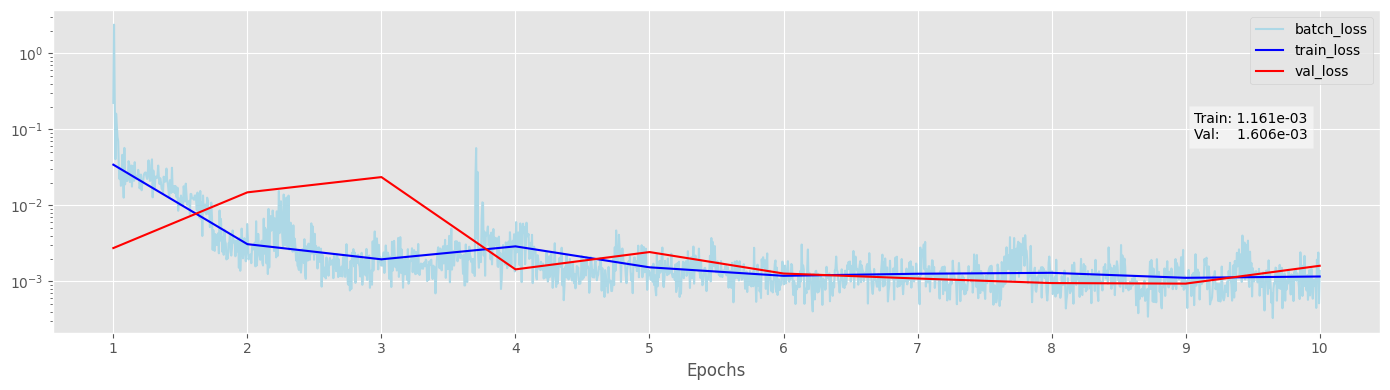

In [ ]:
# PLOT TRAINING PERFORMANCE -----------------------------------------------------------------
# get DataFrame of training metrics:
training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])

# -------------------------------------
NUM_EPOCHS = CONFIG['NUM_EPOCHS']
# plot training performance:
fig, ax1 = plt.subplots(figsize=(14,4))
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(1, NUM_EPOCHS + 1))

assert len(train_losses_per_iter) == NUM_EPOCHS * train_batches, "Length of train_losses_per_iter might not match the number of iterations."
plt.plot(np.linspace(1, NUM_EPOCHS, len(train_losses_per_iter)), train_losses_per_iter, label='batch_loss', color='lightblue')
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train_loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='val_loss', color='red')

plt.yscale('log'); fig.tight_layout(); plt.legend();

plt.text(0.86, 0.6, f"Train: {train_losses[-1]:.3e}\nVal:    {val_losses[-1]:.3e}", \
    transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5));

if pd.Series(lr_history).nunique() > 1:
    ax2 = ax1.twinx()
    ax2.plot(range(1, NUM_EPOCHS + 1), lr_history, label='lr', color='green', linestyle='--')
    ax2.set_ylabel('Learning Rate', color='green'); ax2.tick_params(axis='y', labelcolor='green'); ax2.set_yscale('log')

In [ ]:
# EVALUATION -----------------------------------------------------------------

# get file list of test subset
test_files = checkpoint["test_files"]
# -------------------------------------
# evaluate model on test set
test_loss, outputs, targets, original_lengths = TRAINER.evaluate_model()
# -------------------------------------
all_outputs, all_targets, all_original_lengths = [], [], []
for batch_outputs, batch_targets, batch_lengths in zip(outputs, targets, original_lengths):
    all_outputs.extend(batch_outputs)
    all_targets.extend(batch_targets)
    all_original_lengths.extend(batch_lengths)

# Inverse-transform on all outputs and targets for evaluation
scaled_outputs = [target_scaler.inverse_transform(output_sequence.reshape(1, -1)).squeeze() for output_sequence in all_outputs]
scaled_targets = [target_scaler.inverse_transform(target_sequence.reshape(1, -1)).squeeze() for target_sequence in all_targets]

print(f"Test Loss:  {test_loss:.6f}")
print(f"RMSE: {root_mean_squared_error(np.concatenate(scaled_targets), np.concatenate(scaled_outputs)):.4f}")
print(f"Standard Deviation: {np.std(np.concatenate(scaled_targets) - np.concatenate(scaled_outputs)):.4f}")

Test Loss:  0.001483
RMSE: 5.1489
Standard Deviation: 4.6853


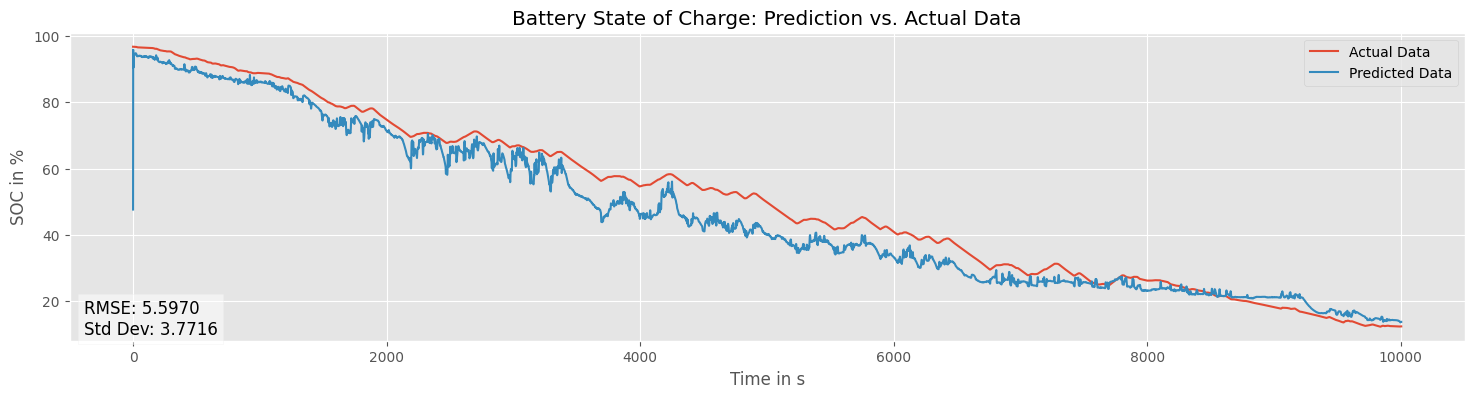

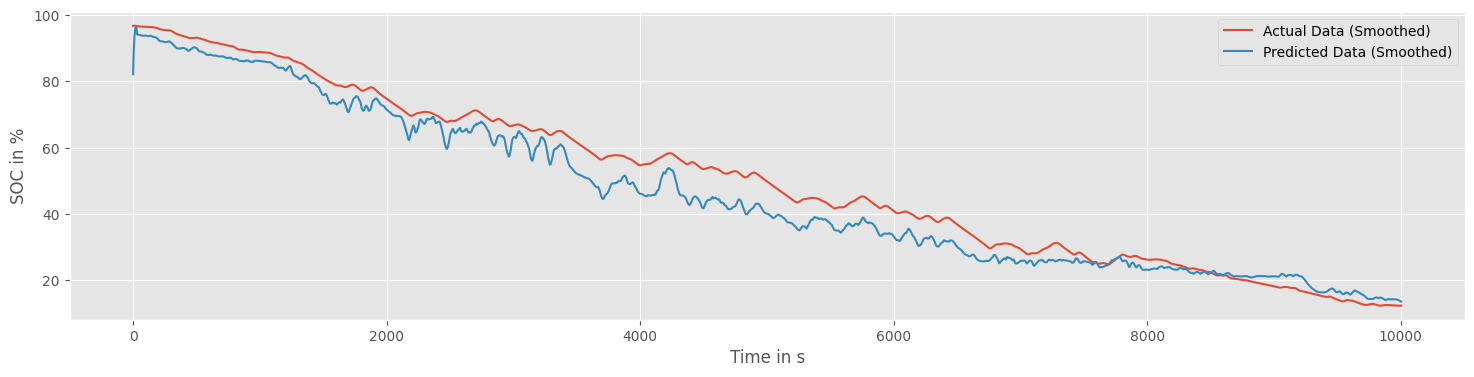

In [ ]:
# PLOT RESULTS -----------------------------------------------------------------
# get random sample sequence from test set
# -------------------------------------
sample_int = random.randint(1, len(scaled_outputs))
y_pred = scaled_outputs[sample_int]
y_true = scaled_targets[sample_int]

###############################################
# PLOT PREDICTION -----------------------------------------------------------------
if PLOT_ACTIVE:
     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %'); plt.title('Battery State of Charge: Prediction vs. Actual Data') 
     plt.plot(y_true, label='Actual Data') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), y_pred, label='Predicted Data') # predicted plot
     plt.legend()
     plt.text(0.01, 0.02, f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}\nStd Dev: {np.std(y_true - y_pred):.4f}",\
          transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

     plt.figure(figsize=(18,4)); plt.xlabel('Time in s'); plt.ylabel('SOC in %')
     plt.plot(savgol_filter(y_true.flatten(), window_length=60, polyorder=3), label='Actual Data (Smoothed)') # actual plot
     plt.plot(np.arange(0, len(y_true), 1), savgol_filter(y_pred.flatten(), window_length=60, polyorder=3), label='Predicted Data (Smoothed)') # predicted plot
     plt.legend();

In [ ]:
'''
TODOs: 
- check if keeping the hidden state between batches is necessary
'''

'\nTODOs: \n- check if keeping the hidden state between batches is necessary\n'